In [1]:
import time
import functools
# JAX library : une nouvelle venue dans le domaine 
#       l'auto-differentiation
#       la compilation Just-In-Time 
#       l'optilisation XLA du code compile pour le device CPU/GPU/TPU

import jax
import jax.numpy as jnp
from jax import random
from jax import grad, jit, vmap, value_and_grad
from jax.example_libraries import optimizers

from jax.config import config
config.update("jax_enable_x64", True)


from jax.example_libraries import stax
from jax.example_libraries.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, LogSoftmax)
print("DEBUG Jax is running on device:",jax.devices())

# Numpy 
import numpy as np

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.style.use('seaborn-white')
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18

# scikit-learn : ici on utilise qq utilitaires pour générer des datas
#     mais on pourrait faire la classification
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Pytorch : ici on utilise un utilitaire pour faire des lots de donnees: training/test + batch
#   mais on pourrait aussi faire de la classification 
from torch.utils.data import Dataset,  DataLoader

DEBUG Jax is running on device: [CpuDevice(id=0)]


# Simple classification en 2D

In [2]:
num_features = 2
num_classes  = 5
batch_size   = 5
# Generate key which is used to generate random numbers
key = random.PRNGKey(42)

# Generations de données

In [3]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k """
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

In [4]:
n_samples = 1500
np.random.seed(0)
X, y= datasets.make_blobs(n_samples=2*n_samples, 
                          centers=num_classes,
                         random_state=70)
# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

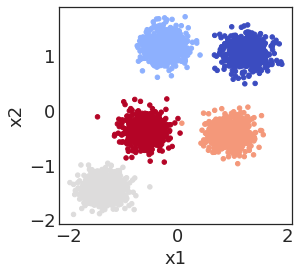

In [5]:
plt.scatter(X[:, 0], X[:, 1], s=20, c=y, cmap=plt.cm.coolwarm)
plt.gca().set_aspect('equal')
plt.xlabel("x1")
plt.ylabel("x2");

In [6]:
# Obtenir des lots de training et de test
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

In [7]:
class MyDataset(Dataset):
    """ Class to use the torch Dataloader mechanism """
    def __init__(self, X,y):
        self.x_data, self.y_data = X,y
    
    def __getitem__(self, i):
        return self.x_data[i], self.y_data[i]

    def __len__(self):
        return len(self.x_data)

In [8]:
dataset_train = MyDataset(X_train,y_train)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_test = MyDataset(X_test,y_test)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [9]:
def plot_performance(train_loss, train_acc, test_acc,
                           sup_title="Loss Curve"):
    """ Visualize the learning performance of a classifier """
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(train_loss)
    axs[0].set_xlabel("# Batch Updates")
    axs[0].set_ylabel("Batch Loss")
    axs[0].set_title("Training Loss")

    axs[1].plot(train_acc, lw=3, label="Training")
    axs[1].plot(test_acc, lw=3, ls="--", label="Test")
    axs[1].set_xlabel("# Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Prediction Accuracy")
    axs[1].legend()

    # Give data more room to bloom!
    for i in range(2):
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)

    fig.suptitle(sup_title, fontsize=25)
    fig.tight_layout(rect=[0, 0.03, 1, 0.925])

In [10]:
class Classif():
    """ Class to optimize a classifier """
    def __init__(self, clf, num_features, num_classes, batch_size):
        
        self.num_features = num_features
        self.num_classes  = num_classes
        self.batch_size   = batch_size

        #initialisation & feed-forward pass    
        self.init_nn, self.apply_nn = clf

        # Optimizer Adam for Gradient Descent
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(1e-3)

    @functools.partial(jit, static_argnums=0)
    def loss(self, params, data, targets):
        """ loss - Sum_i y_i log(p_\theta(x_i)) """
        preds = self.apply_nn(params, data)
        return -jnp.sum(preds * targets)

    @functools.partial(jit, static_argnums=0)
    def update(self, params, x, y, opt_state):
        """ Compute the gradient for a batch and update the parameters """
        value, grads = value_and_grad(self.loss)(params, x, y)
        opt_state = self.opt_update(0, grads, opt_state)
        return self.get_params(opt_state), opt_state, value
    
    def accuracy(self, params, data_loader):
        """ Compute the mean accuracy for a batch """
        acc_total = 0
        for batch_idx, (data, target) in enumerate(data_loader):
            data = jnp.array(data)
            targets = one_hot(np.array(target), self.num_classes)

            target_class = jnp.argmax(targets, axis=1)
            predicted_class = jnp.argmax(self.apply_nn(params, data), axis=1)
            acc_total += jnp.sum(predicted_class == target_class)
        return acc_total/len(data_loader.dataset)


    def run_training_loop(self, num_epochs, train_loader, test_loader, seed=42):
        """ Implements a learning loop over epochs. """
        # Initialize placeholder for loggin
        log_acc_train, log_acc_test, train_loss = [], [], []
        
        key = jax.random.PRNGKey(seed)
        _,params_init = self.init_nn(key, (self.batch_size, self.num_features))
        opt_state = self.opt_init(params_init)

        # Get the initial set of parameters
        params = self.get_params(opt_state)
    
        # Get initial accuracy after random init
        train_acc = self.accuracy(params, train_loader)
        test_acc = self.accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
    
        # Loop over the training epochs
        for epoch in range(num_epochs):
            start_time = time.time()
            for batch_idx, (data, target) in enumerate(train_loader):
                x = jnp.array(data)
                y = one_hot(np.array(target), self.num_classes)
                params, opt_state, loss = self.update(params, x, y, opt_state)
                train_loss.append(loss)

            epoch_time = time.time() - start_time
            train_acc = self.accuracy(params, train_loader)
            test_acc = self.accuracy(params, test_loader)
            log_acc_train.append(train_acc)
            log_acc_test.append(test_acc)
            print(f"Epoch {epoch+1} | T: {epoch_time:0.2f} | Train Acc: {train_acc:0.4f} | Test Acc: {test_acc:0.4f}")

        return train_loss, log_acc_train, log_acc_test, params, params_init

## Models:
- Simple model linéaire 
- Un Neural net à 1 couche cachée et un rectificateur comme non-linéairité

In [19]:
model = stax.serial(Dense(num_classes),
                        LogSoftmax        # compute the log of the softmax
                      )
clf = Classif(model, num_features=num_features, num_classes=num_classes, batch_size=batch_size)

num_epochs=20
train_loss, log_acc_train, log_acc_test, params, params_init = \
        clf.run_training_loop(num_epochs, train_loader, test_loader)

init_nn, apply_nn = model

Epoch 1 | T: 6.37 | Train Acc: 0.3373 | Test Acc: 0.3465
Epoch 2 | T: 5.95 | Train Acc: 0.5333 | Test Acc: 0.5515
Epoch 3 | T: 6.01 | Train Acc: 0.7851 | Test Acc: 0.8121
Epoch 4 | T: 6.19 | Train Acc: 0.8303 | Test Acc: 0.8525
Epoch 5 | T: 6.05 | Train Acc: 0.8602 | Test Acc: 0.8808
Epoch 6 | T: 5.19 | Train Acc: 0.8891 | Test Acc: 0.9162
Epoch 7 | T: 6.17 | Train Acc: 0.9119 | Test Acc: 0.9404
Epoch 8 | T: 6.15 | Train Acc: 0.9313 | Test Acc: 0.9556
Epoch 9 | T: 6.09 | Train Acc: 0.9498 | Test Acc: 0.9646
Epoch 10 | T: 6.23 | Train Acc: 0.9602 | Test Acc: 0.9758
Epoch 11 | T: 6.07 | Train Acc: 0.9692 | Test Acc: 0.9828
Epoch 12 | T: 6.65 | Train Acc: 0.9741 | Test Acc: 0.9869
Epoch 13 | T: 6.35 | Train Acc: 0.9776 | Test Acc: 0.9879
Epoch 14 | T: 5.30 | Train Acc: 0.9851 | Test Acc: 0.9909
Epoch 15 | T: 6.26 | Train Acc: 0.9871 | Test Acc: 0.9909
Epoch 16 | T: 6.31 | Train Acc: 0.9891 | Test Acc: 0.9929
Epoch 17 | T: 6.36 | Train Acc: 0.9920 | Test Acc: 0.9929
Epoch 18 | T: 6.17 | Tr

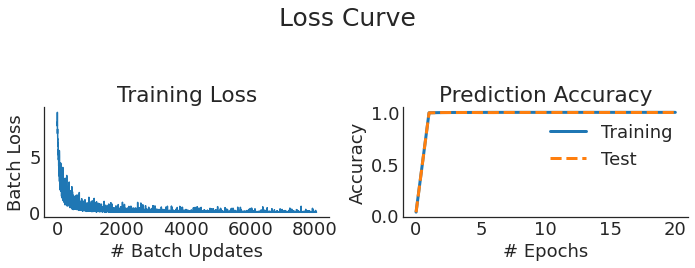

In [16]:
plot_performance(train_loss, log_acc_train, log_acc_test)

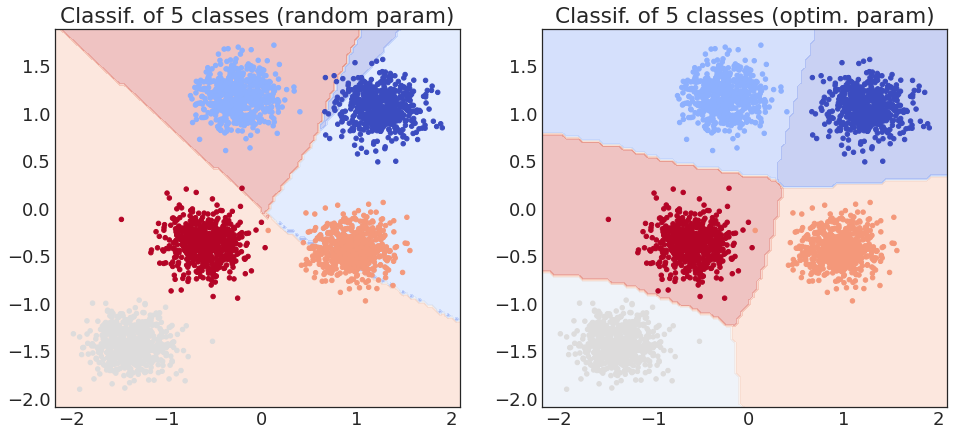

In [17]:
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0])*1.1,np.max(X[:,0])*1.1,100), 
                     np.linspace(np.min(X[:,1])*1.1,np.max(X[:,1])*1.1,100))
positions = jnp.vstack([xx.ravel(), yy.ravel()]).T
predict_init = jnp.argmax(jnp.exp(apply_nn(params_init,positions)),axis=1)
f_init = np.reshape(predict_init,xx.shape)

predict = jnp.argmax(jnp.exp(apply_nn(params,positions)),axis=1)
f = np.reshape(predict,xx.shape)

fig,axs = plt.subplots(1,2,figsize=(16,8))
axs[0].contourf(xx,yy,f_init,cmap=plt.cm.coolwarm, alpha=0.3)
axs[0].scatter(X[:, 0], X[:, 1], s=20, c=y, cmap=plt.cm.coolwarm)
axs[0].set_aspect('equal')
axs[0].set_title(f"Classif. of {num_classes} classes (random param)")

axs[1].contourf(xx,yy,f,cmap=plt.cm.coolwarm, alpha=0.3)
axs[1].scatter(X[:, 0], X[:, 1], s=20, c=y, cmap=plt.cm.coolwarm)
axs[1].set_aspect('equal')
axs[1].set_title(f"Classif. of {num_classes} classes (optim. param)");

In [14]:
n_hidden = 100
model= stax.serial(
        Dense(n_hidden),
        Relu,
        Dense(num_classes),
        LogSoftmax
)

In [15]:
clf1 = Classif(model, num_features=num_features, num_classes=num_classes, batch_size=batch_size)

num_epochs=20
train_loss, log_acc_train, log_acc_test, params, params_init = \
        clf1.run_training_loop(num_epochs, train_loader, test_loader)

init_nn, apply_nn = model

Epoch 1 | T: 6.82 | Train Acc: 0.9960 | Test Acc: 0.9949
Epoch 2 | T: 6.03 | Train Acc: 0.9980 | Test Acc: 0.9980
Epoch 3 | T: 6.17 | Train Acc: 0.9990 | Test Acc: 0.9980
Epoch 4 | T: 5.50 | Train Acc: 0.9990 | Test Acc: 0.9990
Epoch 5 | T: 6.07 | Train Acc: 0.9995 | Test Acc: 0.9980
Epoch 6 | T: 6.36 | Train Acc: 1.0000 | Test Acc: 0.9980
Epoch 7 | T: 6.17 | Train Acc: 1.0000 | Test Acc: 0.9990
Epoch 8 | T: 6.17 | Train Acc: 1.0000 | Test Acc: 0.9990
Epoch 9 | T: 6.30 | Train Acc: 1.0000 | Test Acc: 0.9990
Epoch 10 | T: 6.41 | Train Acc: 1.0000 | Test Acc: 0.9990
Epoch 11 | T: 5.06 | Train Acc: 1.0000 | Test Acc: 0.9990
Epoch 12 | T: 6.40 | Train Acc: 1.0000 | Test Acc: 0.9990
Epoch 13 | T: 6.11 | Train Acc: 1.0000 | Test Acc: 0.9990
Epoch 14 | T: 6.06 | Train Acc: 1.0000 | Test Acc: 0.9990
Epoch 15 | T: 6.21 | Train Acc: 1.0000 | Test Acc: 0.9990
Epoch 16 | T: 5.74 | Train Acc: 1.0000 | Test Acc: 0.9990
Epoch 17 | T: 6.05 | Train Acc: 1.0000 | Test Acc: 0.9990
Epoch 18 | T: 6.07 | Tr

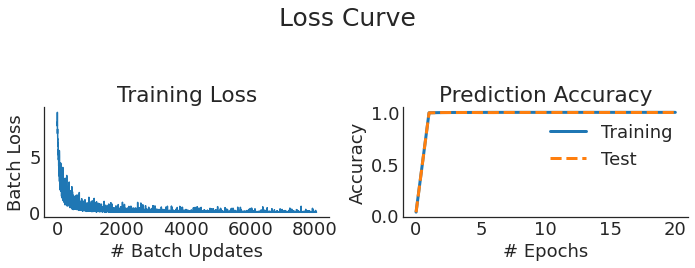

In [18]:
plot_performance(train_loss, log_acc_train, log_acc_test)

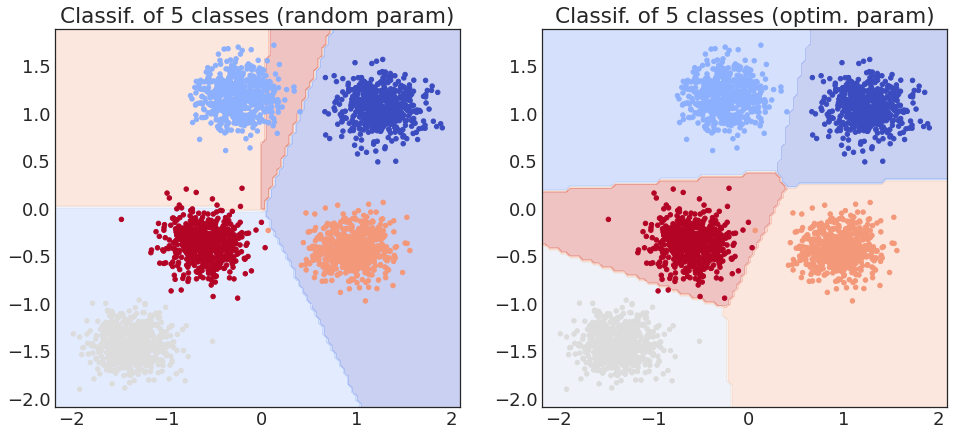

In [103]:
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0])*1.1,np.max(X[:,0])*1.1,100), 
                     np.linspace(np.min(X[:,1])*1.1,np.max(X[:,1])*1.1,100))
positions = jnp.vstack([xx.ravel(), yy.ravel()]).T
predict_init = jnp.argmax(jnp.exp(apply_nn(params_init,positions)),axis=1)
f_init = np.reshape(predict_init,xx.shape)

predict = jnp.argmax(jnp.exp(apply_nn(params,positions)),axis=1)
f = np.reshape(predict,xx.shape)

fig,axs = plt.subplots(1,2,figsize=(16,8))
axs[0].contourf(xx,yy,f_init,cmap=plt.cm.coolwarm, alpha=0.3)
axs[0].scatter(X[:, 0], X[:, 1], s=20, c=y, cmap=plt.cm.coolwarm)
axs[0].set_aspect('equal')
axs[0].set_title(f"Classif. of {num_classes} classes (random param)")

axs[1].contourf(xx,yy,f,cmap=plt.cm.coolwarm, alpha=0.3)
axs[1].scatter(X[:, 0], X[:, 1], s=20, c=y, cmap=plt.cm.coolwarm)
axs[1].set_aspect('equal')
axs[1].set_title(f"Classif. of {num_classes} classes (optim. param)");